<a id="contents"></a>

# NOTEBOOK CONTENT

- [**PROJECT SUMMARY**](#summary)


- [**PROJECT PIPELINE**](#workflow)


- [**DATA FOR THE PROJECT**](#data)


- [**EXPLORATORY DATA ANALYSIS**](#eda)


- [**DATA PREPROCESSING**](#preprocess) 


- [**EXTRACT FEATURES.**](#features) 


- [**ITERATIVE K-MEANS CLUSTERING.**](#kmeans) 


- [**SELECT CLUSTER SIZE.**](#clustsize) 


- [**MODEL ACCURACY**](#accuracy)


- [**VISUALIZATION**](#graphs)


- [**OBSERVATIONS**](#obsvs)


- [**CONCLUSION**](#conclude)


- [**REFERENCES**](#references)

In [3]:
import numpy as np
import pandas as pd
import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bhkosara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bhkosara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<a id="summary"></a>

# PROJECT SUMMARY

## Problem statement

The idea is to implement a text similarity mechanism so that when given a large number of documents written in English, the algorithm should be able to group the documents into categories depending on the content of the documents.

This problem of text classiciation can be solved in a variety of ways, based on the information we gathered on the internet. A few examples are as below:    
1. Using some mini-hashing algorithm along with similarity methods (Jaccard, Cosine, etc.)    
2. Using some numerical representation of words followed by feature extraction followed by some dimensionality reduction method followed by an unsupervised clustering algortithm.

**Within the limitations of this course, we have chosen to implement the second method**.

## Project scope.

The goal of the project is to be able to auto-categorize given set of documents in English (e.g., News articles data selected for this project) into groups using unsupervised clustering mechanisms. The idea is to convert the text data into a numerical representation (e.g., Bag-Of-Words, TF-IDF representation, etc) and then reduce the converted multi-dimensional numerical vectors into manageable number of dimensions (for e.g., 50 dimensions) using Principal Component Analysis, and then eventually use k-means clustering algorithm to the reduced multi-dimensional vector.

<a id="workflow"></a>

# PROJECT PIPELINE

<a id="data"></a>

# DATA FOR THE PROJECT

## About the data.

**Source:** http://qwone.com/~jason/20Newsgroups/

The data in the document repo are in the format of emails sent about some or other specific type of news clippings observed by the email author. I read a comment online saying that the dataset is apparently collected by the Stanford Natrual Language Processing Group over a period of several years.

There are three data sets available.
   - 20news-19997.tar.gz  - Original 20 Newsgroups data set   
   - 20news-bydate.tar.gz - Sorted by date; duplicates and some headers removed (18846 documents)   
   - 20news-18828.tar.gz  - Duplicates removed, only "From" and "Subject" headers (18828 documents)   

The website recommends to use the “20news-bydate” data since some sort of data cleaning is already done, e.g., removal of newsgroup-identifying information removal, etc. And also the data is separated into the train and test sets.

**NOTE:** The dataset is also available from **sklearn** exactly in the same form as the above website except that email headers and footers are removed from the text data of the dataset. I am planning to use this data as I do not see any difference between downloading from "http://qwone.com" or from **sklean**.

The 20 Newsgroups dataset is an aggregation of 18846 newsgroup documents, split evenly across different news groups.

The data is organized into 20 different news groups, wherein each group corresponds to a specific topic.    
**Topic**    
&emsp; - alt.atheism    
&emsp; - comp.graphics    
&emsp; - comp.os.ms-windows.misc   
&emsp; - comp.sys.ibm.pc.hardware   
&emsp; - comp.sys.mac.hardware   
&emsp; - comp.windows.x   
&emsp; - misc.forsale   
&emsp; - rec.autos   
&emsp; - rec.motorcycles    
&emsp; - rec.sport.baseball    
&emsp; - rec.sport.hockey    
&emsp; - sci.crypt    
&emsp; - sci.electronics    
&emsp; - sci.med    
&emsp; - sci.space    
&emsp; - soc.religion.christian    
&emsp; - talk.politics.guns    
&emsp; - talk.politics.mideast    
&emsp; - talk.politics.misc    
&emsp; - talk.religion.misc

## Download the data

We downloaded the data using the function fetch_20newsgroups provided by the sklearn package. This function allows the user to download the data with the email headers, footers, and quotes which I am going to use.

This extra information, i.e., "headers, footers, etc" if not removed can have an effect of overlapping of data all over the place across multiple dimensions of the feature vector leading to poor classification.

**NOTE:** This stage also involves some data preprocessing. The fetch_20newsgroups is invoked to exclude the header, footer, quotes from each document.

**NOTE:** This stage also involves some data preprocessing. The fetch_20newsgroups is invoked to exclude the header, footer, quotes from each document.

In [5]:
from sklearn.datasets import fetch_20newsgroups

#Download all of the data.
all_data_orig = fetch_20newsgroups(subset='all',
                                   remove=('headers', 'footers', 'quotes'),
                                   shuffle=False)

all_df = pd.DataFrame({'data': all_data_orig.data,
                       'target': all_data_orig.target})

In [6]:
train_data_orig = fetch_20newsgroups(subset='train',
                                   remove=('headers', 'footers', 'quotes'),
                                   shuffle=False)

train_df = pd.DataFrame({'data': train_data_orig.data,
                        'target': train_data_orig.target})

In [7]:
test_data_orig = fetch_20newsgroups(subset='test',
                                   remove=('headers', 'footers', 'quotes'),
                                   shuffle=False)

test_df = pd.DataFrame({'data': test_data_orig.data,
                        'target': test_data_orig.target})

<a id="eda"></a>
# EXPLORATORY DATA ANALYSIS

## Describe the data

In [8]:
print(all_data_orig.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [37]:
print("Total file count: %d" %len(all_data_orig.filenames))
print("File-Target association: " + str(all_data_orig.target))
print("Unique targets: %d" %(len(np.unique(all_data_orig.target))))
print("Predetermined targets: %d" %(len(all_data_orig.target_names)))

Total file count: 18846
File-Target association: [ 9  4 11 ...  4  6  7]
Unique targets: 20
Predetermined targets: 20


In [38]:
all_data_orig.filenames.shape

(18846,)

In [39]:
all_data_orig.target.shape

(18846,)

In [40]:
train_data_orig.filenames.shape

(11314,)

In [41]:
test_data_orig.filenames.shape

(7532,)

## Categories of the data
**NOTE:** These were categorized manually by the original data collector.

In [42]:
all_data_orig.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Distribution of files among pre-determined groups

### Distribution of files among pre-determined groups (Full dataset).

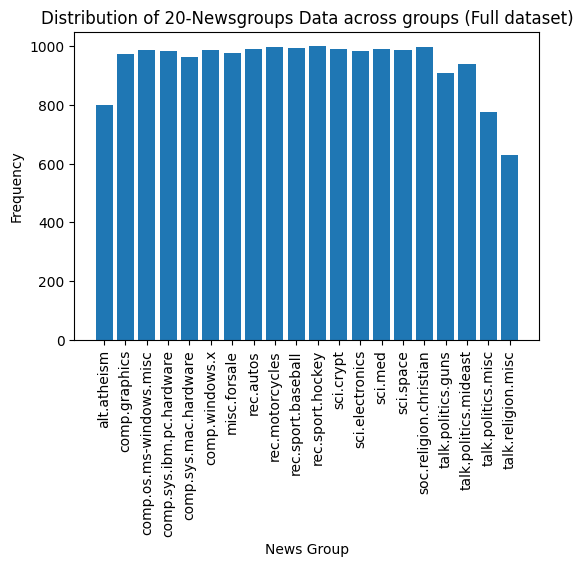

In [43]:
targets, tgt_freq = np.unique(all_data_orig.target, return_counts=True)
target_names = np.array(all_data_orig.target_names)

plt.figure(figsize=(6, 4))
plt.bar(target_names, tgt_freq)
plt.xticks(rotation=90)
plt.title('Distribution of 20-Newsgroups Data across groups (Full dataset)')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

### Distribution of files among pre-determined groups (Training dataset).

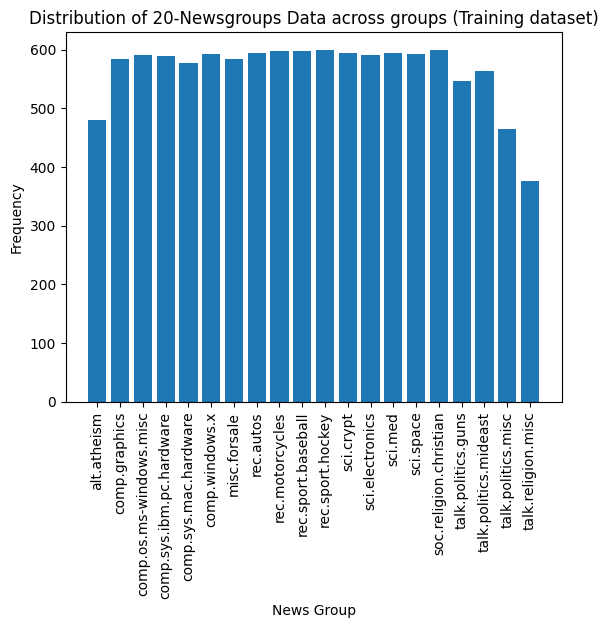

In [44]:
targets, tgt_freq = np.unique(train_data_orig.target, return_counts=True)
target_names = np.array(train_data_orig.target_names)

plt.bar(target_names, tgt_freq)
plt.xticks(rotation=90)
plt.title('Distribution of 20-Newsgroups Data across groups (Training dataset)')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

### Distribution of files among pre-determined groups (Test dataset).

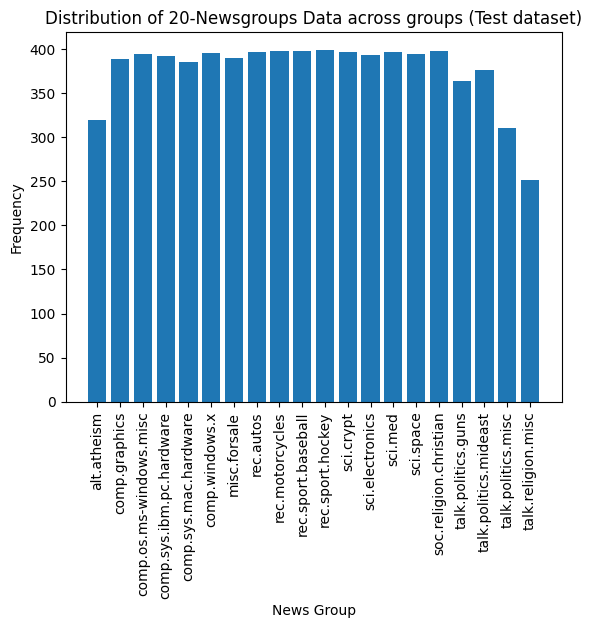

In [16]:
targets, tgt_freq = np.unique(test_data_orig.target, return_counts=True)
target_names = np.array(test_data_orig.target_names)

plt.bar(target_names, tgt_freq)
plt.xticks(rotation=90)
plt.title('Distribution of 20-Newsgroups Data across groups (Test dataset)')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

**NOTE:** It is evident that all of the categories have moderately balanced number of, aka, substantial imbalance does not exist.

## Sample data

In [17]:
all_df

,data,target
0,\nmorgan and guzman will have era's 1 run high...,9
1,"Well, I just got my Centris 610 yesterday. It...",4
2,Archive-name: cryptography-faq/part10\nLast-mo...,11
3,To the best of my knowledge there aren't any p...,4
4,\n\nI think that domestication will change beh...,0
...,...,...
18841,\nWhy are circuit boards green? The material ...,12
18842,\n\nAnybody who drove into somebody like that ...,8
18843,We were told that the resolution on the 5FGe c...,4
18844,CAD Setup For Sale:\n\nG486PLB Local Bus Mothe...,6


## SAMPLE ANALYSIS OF A DOCUMENT CATEGORY.

## Sample word count.

In [18]:
idx = np.nonzero(train_data_orig.target ==
                 train_data_orig.target_names.index('misc.forsale')
                )[0]

count_vect = CountVectorizer()
doc_matrix = count_vect.fit_transform([train_data_orig.data[i] for i in idx])

rownames = [':'.join(filename.split('/')[-2:])
            for filename in train_data_orig.filenames[idx]]

df = pd.DataFrame.sparse.from_spmatrix(doc_matrix,
                                       columns=count_vect.get_feature_names_out(),
                                       index=rownames)

freq_tab = df.sum(axis=0).astype('int')
freq_tab.nlargest(10)

the    1488
for    1157
and    1081
to      967
of      755
in      645
00      617
it      513
is      510
you     477
dtype: int64

## Sample Word cloud.

(-0.5, 399.5, 199.5, -0.5)

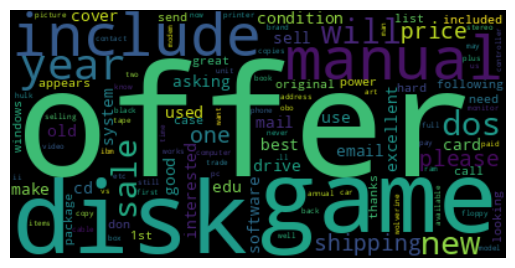

In [19]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(freq_tab.nlargest(200).index))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

<a id="preprocess"></a>

# STAGE-1. DATA PREPROCESSING

## MISSING DATA, DATA IMBALANCE, DATA SCALING

These categories of data preprocessing is not applicable to my dataset.

## Sample data from a file

In [20]:
all_df.iloc[0][0]

"\nmorgan and guzman will have era's 1 run higher than last year, and\n the cubs will be idiots and not pitch harkey as much as hibbard.\n castillo won't be good (i think he's a stud pitcher)"

**NOTE:** I am going to use this sample data to show how the data is getting transformed at each stage of the preprocessing.

## Lower case
Case sensitiviy do not have any role in document classification. So all of the data will be forced to lower case.

In [21]:
def lower_case(x):
    return re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

all_df['data'] = all_df.data.map(lower_case)
all_df.data[0]

'\nmorgan and guzman will have era s 1 run higher than last year  and\n the cubs will be idiots and not pitch harkey as much as hibbard \n castillo won t be good  i think he s a stud pitcher '

## Remove stop words
The stop words, e.g., conjunctions, etc. are not useful in most of the classification problems. I opine that since we are trying to classify the news articles, the stop words may not add much to the accuracy. I will experiment with removal and non-removal of stop words to test the accuracy.

In [22]:
stop_words = set(stopwords.words('english'))
def remove_stop_words(text_data):
    return ' '.join([word for word in text_data.split() if word not in stop_words])

all_df["data"] = all_df["data"].apply(lambda s: remove_stop_words(s))
all_df.data[0]

'morgan guzman era 1 run higher last year cubs idiots pitch harkey much hibbard castillo good think stud pitcher'

## Remove contractions
Convert words like "can't" into cannot "won't" into "will not". This is to standardize text.
Also this helps to not lose the meaning of words like "won't" after removal of punctuation.

In [23]:
import contractions

all_df['data'] = all_df["data"].apply(lambda text: contractions.fix(text))
all_df.data[0]

'morgan guzman era 1 run higher last year cubs idiots pitch harkey much hibbard castillo good think stud pitcher'

## Remove punctuation
This can lead to wrong classification depending on the data type that we are trying to classify.    
We chose to remove punctuation.

In [24]:
all_df['data'] = all_df["data"].apply(lambda s: ' '.join(re.sub("[.,!?:;-='...\"@#_]", " ", s).split()))
all_df.data[0]

'morgan guzman era 1 run higher last year cubs idiots pitch harkey much hibbard castillo good think stud pitcher'

## Remove all numbers
I chose to remove numerics as I felt that numbers do not play a role in classification of data.

In [25]:
all_df["data"] = all_df["data"].map(lambda text: re.sub("\d+", '', text))
all_df.data[0]

'morgan guzman era  run higher last year cubs idiots pitch harkey much hibbard castillo good think stud pitcher'

## Remove all strings of size **1**.
**NOTE:** These single letter words may form after removal of puncutation, numbers, etc.

In [ ]:
all_df["data"] = all_df["data"].map(lambda text: re.sub(" [a-z] ", ' ', text))
all_df.data[0]

## Zipf's law to check on the impact of words based on frequency.

Zipf's law states that the frequency of a token in a text is directly proportional to its rank or position in the sorted list.
This law describes how tokens are distributed in languages: some tokens occur very frequently, some occur with intermediate frequency, and some tokens rarely occur.

When words are ranked according to their frequencies in a large enough collection of texts and then the frequency is plotted against the rank, the result is a logarithmic curve.

The Zipf distribution is used to model situations in which a few observations have a very high value (or impact) and account for a large part of the total, while a very long tail of observations have medium, small, or very small values.

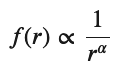

**r** is called the frequency rank of a word, and.   
**f(r)** is its frequency in a natural corpus.

### Plot Zipf's law

Text(0.5, 1.0, "Zipf's law")

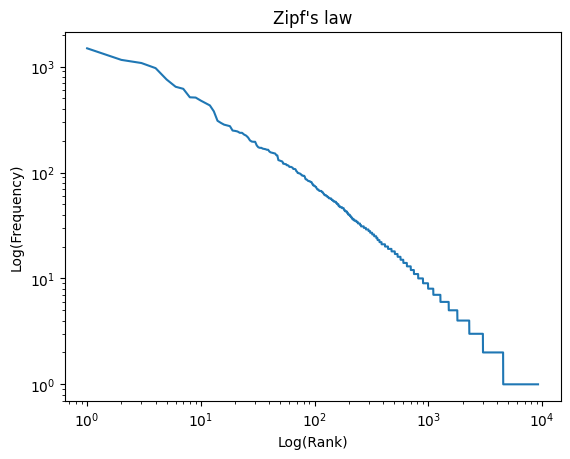

In [26]:
xs = freq_tab.sort_values(ascending=False).reset_index(drop=True, )
plt.loglog(xs.index + 1, xs)
plt.xlabel('Log(Rank)')
plt.ylabel('Log(Frequency)')
plt.title("Zipf's law")

**NOTE:** I am contemplating to remove less impactful words from the dataset as part of preprocessing.
I don't know the impact of this preprocessing yet. I am assuming that the accuracy will be similar between "dataset with impactful words" and "full dataset". If nothing, I might get to save processing time with "dataset with impactful words" because of reduced dataset.

In [28]:
TBD

'morgan guzman era  run higher last year cubs idiots pitch harkey much hibbard castillo good think stud pitcher'

## Lemmatize words    
The goal is to reduce the inflectional forms, and sometimes derivationally related forms of words to a common base word.    
A few examples below:    
  - “fishing”, “fished”, “fisher” will stem to “fish”.    
  - “am”, “are”, will lemmatize to “be”.

In [29]:
tokenizer  = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)])

all_df["data"] = all_df["data"].apply(lemmatize)
all_df.data[0]

'morgan guzman era run higher last year cub idiot pitch harkey much hibbard castillo good think stud pitcher'

<a id="features"></a>

# STAGE-2. Extract features using TF-IDF sparse vectorizer.

Text documents are generally nothing but a bunch of words. In order to perform any statistical analysis using computers, the text files are to be converted into numerical format. 

We are going to to use TF-IDF (Term Frequencues Inverse Document Frequency) methodology. The TF-IDF is a statistical methodology that evaluates the relevance of a word to a specific document in a given collection of documents.

Term frequency, tf(t,d), is the relative frequency of term t within document d,    
<font size="4"> $tf(t,d) = $ $\Large \frac{f_{t,d}} {\sum_{t^` \in d} f_{t^`,d}}$</font>.   

where $f_{t,d}$ is the raw count of a term in a document, i.e., the number of times that term t occurs in document d.  

Inverse document frequency is a measure of how much information the word provides if it is common across all of the documents.    
<font size="4">$tf(t,d) = $ $\Large\frac{f_{t,d}} {\sum_{t^` \in d} f_{t^`,d}}$</font>.   
N: Total number of documents in the corpus.    

<font size="4">$|\{d \in D: t \in d\}|$</font>: is the number of documents where the term t appears.

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(train_df.data)
X.shape

<a id="kmeans"></a>

# STAGE-3. Iterate k-means with different cluster sizes.

In [ ]:
def cluster_search_kmeans(data, clust_range,
                          batch=True, batch_size=2048):
    wcss=[]
    silh=[]
    
    for nclust in clust_range:
        if batch == False:
            model = KMeans(nclust)
        else:
            model = MiniBatchKMeans(init="k-means++",
                                    n_clusters=nclust,
                                    batch_size=batch_size,
                                    random_state=3)
        
        y = model.fit_predict(data)
        
        wcss.append(model.inertia_)
        silh.append(silhouette_score(data,y))
    
    return wcss, silh

def generate_analyze_kmeans_model(X, K, cluster_size, vectorizer):  
    k_means_model = KMeans(n_clusters=cluster_size,
                           init='random',
                           n_init=1,
                           verbose=0,
                           random_state=42)
    
    k_means_model.fit(X)
    cluster_centers = k_means_model.cluster_centers_

    order_centroids = cluster_centers.argsort()[:, ::-1]
    features = vectorizer.get_feature_names()
    
    for i in range(cluster_size):
        print("Cluster-%d:" % i)
        word_list = []
        for ind in order_centroids[i, :K]:
            word_list.append(features[ind])
        print(str(word_list))
        print("")
        
    return k_means_model

In [ ]:
clust_range = range(3, 16) #[min, max)

wcss, silh = cluster_search_kmeans(X,
                                   clust_range,
                                   True, #Batch k-means
                                   2048) #Batch size (256x8 <- 8 cores)

<a id="clustsize"></a>

# STAGE-4. Select cluster size.

## Use Elbow method to select cluster size.

**Elbow method**
Plot the WCSS values for each cluster size and pick the cluster size at which point the curve seems to have plateued after a steep fall (elbow point).     

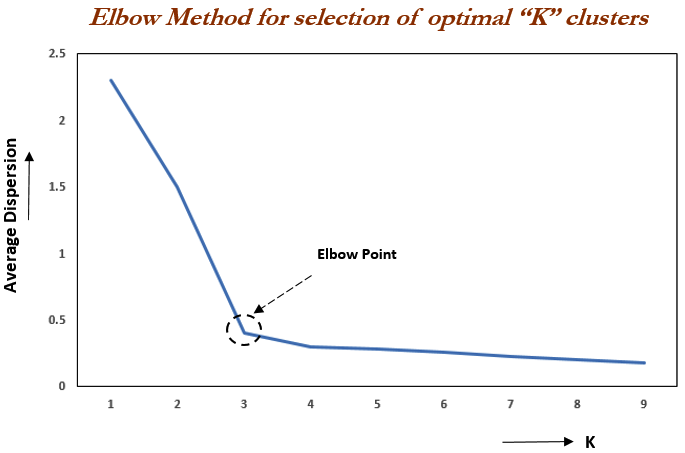    
**NOTE**: This figure is not a representation of actual data of this project. This is just for pictorial represenation of how Elbow method works.

**Source of the image**: "Statistics for Machine Learning by Pratap Dangeti.

**NOTE:** If the Elbow method does not give a conclusive guidane on the cluster size to pick, then utilize the Silhoutte score for each data point to determine the optimal cluster size.

In [ ]:
def plot_wcss(clust_range, wcss):
    fig,a =  plt.subplots(1,1)
    plt.plot(clust_range,wcss)
    plt.title('WCSS vs. Number of clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

plot_wcss(clust_range, wcss)

In [ ]:
kmeans_model_1 = generate_analyze_kmeans_model(X, 50, 11, vectorizer)

## Use Silhoutte score method to select cluster size.

**Silhoutte value s(i) for each data point is defined as:**   
<font size="4">$s(i) = \frac{b(i) - a(i)} {\max\{a(i), b(i)\}}$, if $|C_i| > 1 $</font>.   
and   
<font size="4">$s(i) = 0$, if $|C_i| = 1$</font>

**a(i)** is the measure of similarity of the point i to its own cluster. It is measured as the average distance of i from other points in the cluster.    
For each data point $i \in C_i$ (data point **i** in the cluster $C_i$</font>, let    
<font size="4">$a(i) = \frac{1} {|C_i| - 1} \sum \limits _{j \in C_i , i \neq j} d(i,j)$</font>

**b(i)** is the measure of dissimilarity of i from points in other clusters.    
<font size="4">$b(i) = \min \limits _{i \neq j} \frac{1} {|C_j|} \sum \limits _{j \in C_j} d(i, j)$</font>

Once the Silhoutte scores are computed for each cluster size, select the cluster size with the highest Silhoutte score.

**Source: Wikipedia**

In [ ]:
def plot_silhoutte(clust_range, silh):
    fig,b =  plt.subplots(1,1)
    plt.plot(clust_range,silh)
    plt.title('Silhoutte score vs. Number of clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhoutte scores')
    plt.show()

In [ ]:
plot_silhoutte(clust_range, silh)

max_sil = max(silh)
max_idx = silh.index(max_sil)
recomend_clust_size = clust_range[0] + max_idx

print("Cluster size with highest silhoutte score: %d" %(recomend_clust_size))

In [ ]:
kmeans_model_2 = generate_analyze_kmeans_model(X,
                                             40, #Top n-words
                                             recomend_clust_size,
                                             vectorizer)

<a id="accuracy"></a>

# MODEL ACCURACY
This is not a classification model. So model accuracy is not really relevant.

<a id="graphs"></a>

# VISUALIZATION

## Visualization of the clusters.

It is not feasible to visualize a plot in more than 3-dimesions.

The idea is to reduce the dimensions of the feature vector from **172641 dimensions** to **2 dimensions** using **Principal Component Analysis** and then use a scatter-plot to show the distribution of the data in reduced dimensions across the clusters.

Even though the dimesnions are reduced, the reduced data is expected to preserve most of the information.

## Use PCA to reduce feature vector dimensions.

In [ ]:
# Init PCA with just 2 components
pcaModel = PCA(n_components=2, random_state=372)

# Fit and transform the data.
pca_data = pcaModel.fit_transform(X.toarray())

In [ ]:
## Visualize using pca components and the classification from k-means (K=11).

In [ ]:
def plot_pca(labels, pca_data, remap):
    visual_df = pd.DataFrame(columns=['cluster_id', 'pca_0', 'pca_1'])
    visual_df['cluster_id'] = labels
    visual_df['cluster_id'] = visual_df['cluster_id'].apply(remap)
    visual_df['pca_0'] = pca_data[:, 0]
    visual_df['pca_1'] = pca_data[:, 1]

    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    sns.scatterplot(data=visual_df,
                    x='pca_0',
                    y='pca_1',
                    hue='cluster_id',
                    palette="viridis").set(title='20news-group clustering')

In [ ]:
def remap_1(class_type):
    if class_type == 0:
        return "Unspecific"
    elif class_type == 1:
        return "Sales"
    elif class_type == 2:
        return "Government"
    elif class_type == 3:
        return "Computer hardware + cryptos + govt"
    elif class_type == 4:
        return "Computer software"
    elif class_type == 5:
        return "Medicine"
    elif class_type == 6:
        return "Computer hardware"
    elif class_type == 7:
        return "Sports"
    elif class_type == 8:
        return "Cars"
    elif class_type == 9:
        return "Religion"
    elif class_type == 10:
        return "Email"
    
plot_pca(kmeans_model_1.labels_, pca_data, remap_1)

## Visualize using pca components and the classification from kmeans (K=3).

In [ ]:
def remap(class_type):
    if class_type == 0:
        return "sports"
    elif class_type == 1:
        return "technology (HW and SW)"
    else:
        return "politics and religion"

plot_pca(kmeans_model_2.labels_, pca_data, remap_1)

## Pie chart of clusters and the count of documents in each cluster.

In [ ]:
From Harvard

## 4 dimensions of encoded documents.

In [ ]:
From Harvard

<a id="obsvs"></a>

# OBSERVATIONS.

Referring to the "About Data" section again,

The visual inspection of the document categories appears to be as follows in no particular order:  
  - "politics"  
  - "religion"  
  - "sports and cars"  
  - "computer hardware"  
  - "Misc: electronics, medicine, crpto,etc"  
  - "for sale"  
  
In general, notice that documents under "computer hardware" and "Misc" categories will have a heavy overlap.

Also "Misc" and "For sale" can also have an overlap.

**NOTE:** Trying to curve fit to achieve the same **6 categories** as above is not a correct approach.

## Observations on the cluster-size "3"

Based on the keywords in each category for **cluster size of 3**, I could infer that the implementation has categorized the documents as follows:  
  - "politics and religion"  
  - "sports and cars"  
  - "Everything else: computer hardware, electronics, medicine, cryptos, etc."   

In a theoritical sense the classification is **resonably correct**. But there are overlaps between the clusters as shown in the scatter-plot above, especially between the "technology" and "sports and cars" categories. This overlap can be explained because there are definitely commond words used among the texts of different categories, which when transformed into TF-IDF vectorization may lead to similarities in some of the feature dimensions.  

## Observations on cluster-size "11".

Based on the keywords in each category for **cluster size of 11**, I could infer that the implementation has categorized the documents as follows:  
  - Cluster-0: Unspecific
  - Cluster-1: Sales
  - Cluster-2: Government
  - Cluster-3: Computer hardware + cryptos + govt
  - Cluster-4: Computer software
  - Cluster-5: Medicine
  - Cluster-6: Computer hardware
  - Cluster-7: Sports
  - Cluster-8: Cars
  - Cluster-9: Religion
  - Cluster-10: Email
  
I was pleasantly surprised that even the classification using a cluster size of **11** is is also **resonably correct** even though I thought that the **Elbow method** did not give a conclusive answer. The only pitfall here is that I could not correctly give an English name to "cluster-0".

## Some pitfalls observed.

**unigram vs n-gram**
Words like ["Ram", "car"] are considered as unigrams. An n-gram represents **n** number of words as one single entity, e.g., "bus has", etc. 

Instead of using unigrams, a bigram, trigram, or some n-gram might be able to provide much better classification.

<a id="conclude"></a>

# CONCLUSION

It is been demonstrated in this project that using a combination of TF-IDF feature vector generation, and k-means clustering, a given bunch of text documents in English can be classified into meaningful groups via unsupervised learning without having any labled data as a reference.

<a id="references"></a>

# REFERENCES

Wikipedia